This code features finite volume implimentation of solid spherical diffusion of lithium. This notebook details FVM calculations and its Julia implimentation. The notebook helps generate diffusion matrix to be incorporated into any electrochemical model. The notebook also features a simple example of how to use the diffusion matrix to solve for concentration profile in a spherical particle and effect of mesh size on the solution.

The code is implimented by Jishnu Ayyangatu Kuzhiyil. At the time of writing the code, Jishnu is a PhD student at the University of Warwick.

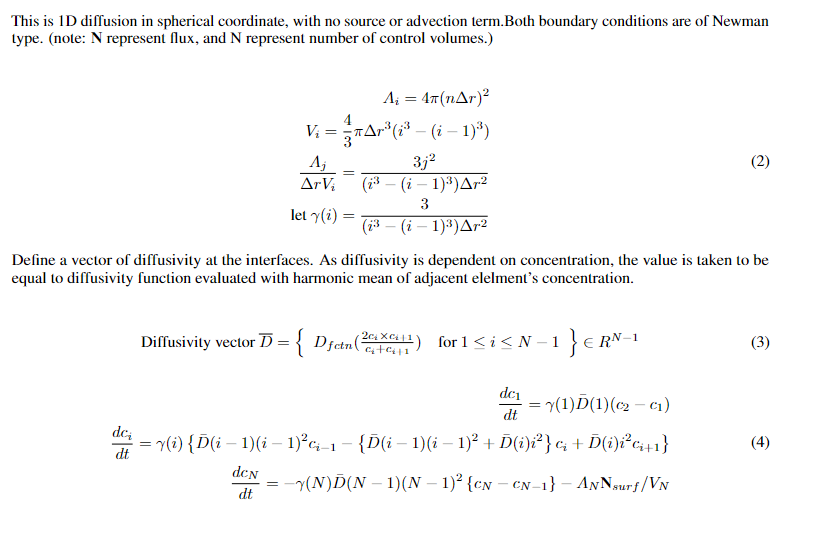

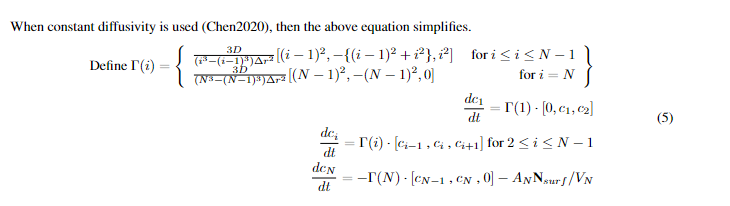

In this code, the constant diffusivity (independent of concentration) is assumed. 

In [79]:
# Getting into implimentation, I will be using the Julia programming language. I will be using the following packages:

using LinearAlgebra,DifferentialEquations,Plots,SparseArrays,BenchmarkTools,PreallocationTools

# I will be using the following parameters:

D=4e-15  # Diffusion coefficient [m^2/s]
R=5.22e-6 # Radius of the particle [m]
N=10 # Number of FVM control volumes [-]
L =75.6e-6 # Length of the electrode [m]
ϵ_s = 0.665 # Solid phase volume fraction [-]
b=3*ϵ_s/R #Area to volume ratio [1/m]


A=0.1 #Area of the electrode
I=-5   # Current [A]
Duration=1800 # Duration of the simulation [s]
F=96485 # Faraday constant [C/mol]
c0=17038.0 # Initial concentration [mol/m^3]




17038.0

In [80]:

ΔR=R/N # Width of the control volume along radial direction [m]

function generate_Diff_matrix(D,R,N;Save_Diff_Matrix=false)

    ΔR=R/N # Width of the control volume along radial direction [m]

    function diag_p(i)

        a=3*D/(ΔR^2)/ (i^3-(i-1)^3)
        b=-(i-1)^2-i^2
        return a*b
    end 

    function Upperdiag_p(i)

        a=3*D/(ΔR^2)/ (i^3-(i-1)^3)
        b=(i)^2
        return a*b
    end 

    function Lowerdiag_p(i)

        a=3*D/(ΔR^2)/ (i^3-(i-1)^3)
        b=(i-1)^2
        return a*b
    end 

    diag=[[diag_p(i) for i=1:N-1]; -Lowerdiag_p(N)]
    Upperdiag=[Upperdiag_p(i) for i=1:N-1]
    Lowerdiag=[Lowerdiag_p(i) for i=2:N]

    Particle_StateMatrix=Tridiagonal(Lowerdiag,diag,Upperdiag)
    A_by_V = 3*N^2/(N^3-(N-1)^3)/ΔR

    if Save_Diff_Matrix
        open("Diffusion_State_Matrix.txt", "w") do f
            write(f, "D: $(D)\n")
            write(f, "R: $(R)\n")
            write(f, "N: $(N)\n")
            write(f, "area to vol for last control volume: $(A_by_V)\n")
            write(f, "diag: $(diag)\n")
            write(f, "Upperdiag: $(Upperdiag)\n")
            write(f, "Lowerdiag: $(Lowerdiag)\n")
            write(f, "Particle_StateMatrix=Tridiagonal(Lowerdiag,diag,Upperdiag)\n")
            write(f, "Flux_right_side_mol_per_m2_per_s: I/(AL)/(Fb) where I/(AL) is j with unit A/m3 \n")
            write(f, "BC_right_side: dc[end]=dc[end](from matrix mult) - N_surf*A_by_V \n")
            write(f, "Particle_StateMatrix: $(Particle_StateMatrix)\n")
        end
    end

    return Particle_StateMatrix,diag,Upperdiag,Lowerdiag
end

generate_Diff_matrix(D,R,N;Save_Diff_Matrix=true)[1]


10×10 Tridiagonal{Float64, Vector{Float64}}:
 -0.0440393    0.0440393     ⋅         …    ⋅           ⋅           ⋅ 
  0.00629133  -0.0314566    0.0251653       ⋅           ⋅           ⋅ 
   ⋅           0.00927143  -0.0301321       ⋅           ⋅           ⋅ 
   ⋅            ⋅           0.0107123       ⋅           ⋅           ⋅ 
   ⋅            ⋅            ⋅              ⋅           ⋅           ⋅ 
   ⋅            ⋅            ⋅         …    ⋅           ⋅           ⋅ 
   ⋅            ⋅            ⋅             0.0169915    ⋅           ⋅ 
   ⋅            ⋅            ⋅            -0.0294464   0.0166776    ⋅ 
   ⋅            ⋅            ⋅             0.0129885  -0.0294272   0.0164386
   ⋅            ⋅            ⋅              ⋅          0.013163   -0.013163

Now lets perform a grid convergence study to see how the solution changes with mesh size. We will use the same parameters as above, but with different mesh sizes.

In [81]:
Test_mesh_sizes=[3,6,9,12,15]
time_to_plot=1800.0
plots=plot()



for i = Test_mesh_sizes

    D_matrix = generate_Diff_matrix(D,R,i;Save_Diff_Matrix=true)[1]
    ΔR=R/i # Width of the control volume along radial direction [m]
    c0_vec= c0*ones(i)

    function ODE_Diffusion!(dc,c,p,t)

        mul!(dc,D_matrix,c)

        j = I/A/L # Current density [A/m^3]
        N_surf = j/(F*b) # Surface flux [mol/m^2]
        A_by_V = 3*i^2/(i^3-(i-1)^3)/ΔR # Area to volume ratio  of last control volume[1/m]

        dc[end] = dc[end] - N_surf*A_by_V # Boundary condition at the surface

    end

    tspan=(0.0,Duration)
    prob=ODEProblem(ODE_Diffusion!,c0_vec,tspan)
    sol=solve(prob,saveat=1.0)

    x_points=[0;[(i-0.5)*ΔR for i=1:i];R]
    solution=sol(time_to_plot)
    y_0=1.5*solution[1]-0.5*solution[2]
    y_end=1.5*solution[end]-0.5*solution[end-1]
    y_points=[y_0;solution;y_end]

    plot!(plots,1e6.*x_points,y_points,label="N=$(i)",lw=2,marker=:circle)
    xlabel!("r [μm]")
    ylabel!("Concentration [mol/m^3]")
    title!("Finite Volume Method for particle diffusion")
    xlims!((0,1e6*R))
    plot!(plots,dpi=300,framestyle=:box)

    
  
end 
savefig(plots,"Diffusion.png")


"m:\\Calendar ageing GB\\codes\\Diffusion.png"